In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier; 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import AgglomerativeClustering


from skimage.color import rgb2hed
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
from skimage.morphology import area_opening


import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as image_fun


import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.neural_network import MLPClassifier; from sklearn.neural_network import MLPRegressor
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix


import glob
import os
import sys
import math
import copy

import scipy as sp
from scipy import ndimage as ndi

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm

import sys; 
from typing import Optional, Union
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
from numpy import array, argmax, load
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import fisher_exact


import warnings
warnings.filterwarnings("ignore")
Path="/content/drive/MyDrive/"

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install lime
import lime; from lime import lime_image

     |████████████████████████████████| 275 kB 5.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=441943e58a82c8fa44f66aed27cb27fed965fc5dce35633fc2e2fba57d560f8e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
h5ad = pd.read_csv(Path+"h5ad_obs.csv", index_col=0)
h5ad['tile_tissue_mask_path'] = h5ad['tile_tissue_mask_path'].str.split('/', expand=True)[3].str[:-5]
h5ad.head(2)

,in_tissue,array_row,array_col,imagecol,imagerow,tile_tissue_mask_path,tissue_area,tile_path,library_id
GATAAGGGACGATTAG-1-1142243F,1,1,3,12601,4511,1142243F-12601-4511-299,0.733437,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
TGTTGGCTGGCGGAAG-1-1142243F,1,1,5,12872,4512,1142243F-12872-4512-299,0.878391,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F


In [4]:
gene_exp = pd.read_csv(Path+"gene_expression_visium.csv", index_col=0)
gene_exp.head(3)

,CD74,CD24,CD63,CD81,CD151,COX6C,TP53,PABPC1,GNAS,B2M,SPARC,HSP90AB1,TFF3,ATP1A1,FASN
GATAAGGGACGATTAG-1-1142243F,1.386294,2.484907,1.386294,0.693147,1.386294,2.079442,0.000000,2.564949,1.945910,2.197225,1.098612,2.079442,0.0,1.386294,0.000000
TGTTGGCTGGCGGAAG-1-1142243F,1.945910,1.098612,1.791759,1.609438,1.098612,2.484907,0.693147,2.302585,2.302585,1.945910,1.609438,1.945910,0.0,1.386294,0.000000
GCGAGGGACTGCTAGA-1-1142243F,2.484907,2.197225,1.791759,1.386294,1.609438,2.708050,1.098612,2.944439,2.772589,2.397895,2.484907,2.397895,0.0,1.386294,0.693147


In [5]:
h5ad = h5ad.set_index(['tile_tissue_mask_path'])
h5ad.head(2)

,in_tissue,array_row,array_col,imagecol,imagerow,tissue_area,tile_path,library_id
tile_tissue_mask_path,,,,,,,,
1142243F-12601-4511-299,1,1,3,12601,4511,0.733437,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F
1142243F-12872-4512-299,1,1,5,12872,4512,0.878391,/clusterdata/uqxtan9/Xiao/breast_cancer_9visiu...,1142243F


In [6]:
resnet_features = pd.read_csv(Path+"Resnet50_features.csv", index_col=0).iloc[:,1:]
resnet_features.index = h5ad.index
resnet_features['dataset'] = resnet_features.index.to_series().str.split('-', expand=True)[0]
resnet_features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,dataset
tile_tissue_mask_path,,,,,,,,,,,,,,,,,,,,,
1142243F-12601-4511-299,0.193142,0.515446,0.058873,0.017709,1.126994,0.077006,0.635040,0.416904,0.172619,0.077006,...,0.018395,0.145082,0.000000,0.011642,0.035087,0.0,0.267840,0.080442,0.319723,1142243F
1142243F-12872-4512-299,0.363417,0.081720,0.000000,0.004373,0.426668,0.030711,0.250733,0.009935,0.109983,0.057820,...,0.061174,0.048635,0.011412,0.012749,0.041346,0.0,0.143626,0.001145,0.152364,1142243F


In [7]:
X_train_resnet = resnet_features.loc[((resnet_features['dataset'] == "block1"))]

#Resnet
X_test_resnet_FFPE =  resnet_features.loc[(resnet_features['dataset'] == "FFPE")]
X_test_resnet_1160920F =  resnet_features.loc[(resnet_features['dataset'] == "1160920F")]
X_test_resnet_1142243F =  resnet_features.loc[(resnet_features['dataset'] == "1142243F")]
X_test_resnet_CID4290 =  resnet_features.loc[(resnet_features['dataset'] == "CID4290")]
X_test_resnet_CID4465 =  resnet_features.loc[(resnet_features['dataset'] == "CID4465")]
X_test_resnet_CID44971 =  resnet_features.loc[(resnet_features['dataset'] == "CID44971")]
X_test_resnet_CID4535 =  resnet_features.loc[(resnet_features['dataset'] == "CID4535")]
X_test_resnet_block2 =  resnet_features.loc[(resnet_features['dataset'] == "block2")]


gene_exp['dataset'] = list(resnet_features['dataset'])
Y = gene_exp.loc[(gene_exp['dataset'] == "block1")]
test_Y_FFPE = gene_exp.loc[(gene_exp['dataset'] == "FFPE")]
test_Y_1160920F = gene_exp.loc[(gene_exp['dataset'] == "1160920F")]
test_Y_1142243F = gene_exp.loc[(gene_exp['dataset'] == "1142243F")]
test_Y_CID4290 = gene_exp.loc[(gene_exp['dataset'] == "CID4290")]
test_Y_CID4465 = gene_exp.loc[(gene_exp['dataset'] == "CID4465")]
test_Y_CID44971 = gene_exp.loc[(gene_exp['dataset'] == "CID44971")]
test_Y_CID4535 = gene_exp.loc[(gene_exp['dataset'] == "CID4535")]
test_Y_block2 = gene_exp.loc[(gene_exp['dataset'] == "block2")]

In [8]:
model_c = MLPClassifier(max_iter=10000, hidden_layer_sizes=(150,100,50), early_stopping=True, random_state=0, activation = 'tanh')

Y = np.log(2*(Y.iloc[:,:-1])+1)
Y = preprocessing.StandardScaler().fit_transform(Y) 
Y = pd.DataFrame(data=Y)
Y = Y.apply(lambda x: [0 if y <= 0 else 1 for y in x])
Y = Y.astype('int64')

def test_set(set_name):
    set_name = np.log(2*(set_name.iloc[:,:-1])+1)
    set_name = preprocessing.StandardScaler().fit_transform(set_name) 
    set_name = pd.DataFrame(data=set_name)
    set_name = set_name.apply(lambda x: [0 if y <= 0 else 1 for y in x])    
    set_name = set_name.astype('int64')
    return set_name
    
test_Y_FFPE = test_set(test_Y_FFPE)
test_Y_1160920F = test_set(test_Y_1160920F)
test_Y_1142243F = test_set(test_Y_1142243F)
test_Y_CID4290 = test_set(test_Y_CID4290)
test_Y_CID4465 = test_set(test_Y_CID4465)
test_Y_CID44971 = test_set(test_Y_CID44971)
test_Y_CID4535 = test_set(test_Y_CID4535)
test_Y_block2 = test_set(test_Y_block2)

In [9]:
#clf_resnet = MultiOutputClassifier(model_c).fit(X_train_resnet.iloc[:,:-1], Y)
#joblib.dump(clf_resnet, Path+'pickle/resnet_block1_log_scaled.pkl')
clf_resnet = joblib.load(Path+'resnet_block1_log_scaled.pkl')
pred_resnet_FFPE = clf_resnet.predict(X_test_resnet_FFPE.iloc[:,:-1])
pred_resnet_1160920F = clf_resnet.predict(X_test_resnet_1160920F.iloc[:,:-1])
pred_resnet_1142243F = clf_resnet.predict(X_test_resnet_1142243F.iloc[:,:-1])
pred_resnet_CID4290 = clf_resnet.predict(X_test_resnet_CID4290.iloc[:,:-1])
pred_resnet_CID4465 = clf_resnet.predict(X_test_resnet_CID4465.iloc[:,:-1])
pred_resnet_CID44971 = clf_resnet.predict(X_test_resnet_CID44971.iloc[:,:-1])
pred_resnet_CID4535 = clf_resnet.predict(X_test_resnet_CID4535.iloc[:,:-1])
pred_resnet_block2 = clf_resnet.predict(X_test_resnet_block2.iloc[:,:-1])

In [10]:
gene_list_2 = gene_exp.columns[:-1].to_list()
resnet_model1 = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")

def model_predict_gene(gene):
    i = gene_list_2.index(gene)
    def combine_model_predict(tile1):
        feature1 = resnet_model1.predict(tile1)
        prediction = clf_resnet.predict_proba(feature1)#[0]
        return prediction[i]#.reshape(-1,1)
    return combine_model_predict

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=0.01)
    thresh = skimage.filters.threshold_otsu(annotation_h)*0.7
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

def cell_summary(file_path,cell_type_input):
    cell_summary_tile = pd.read_csv(file_path)
    return cell_summary_tile.loc[(cell_summary_tile['cell_type'] == cell_type_input)]

def IOU(Ref_mask,Lime_mask):
    Lime_mask[Lime_mask == -1] = 0
    coordinate_x = np.array(round(Ref_mask['coordinate_x'])).astype('int64')
    coordinate_y = np.array(round(Ref_mask['coordinate_y'])).astype('int64')
    mask_initialised = np.array([[0]*299]*299)
    mask_initialised[coordinate_x,coordinate_y] = 1
    
    overlap = mask_initialised*Lime_mask # Logical AND
    return overlap.sum()/float(mask_initialised.sum())

def LIME_p_value(heatmap_cancer, heatmap_immune, cell_summary_Tumor, cell_summary_lymphocyte_stroma, cancer_mask, immune_mask):
  tumor_lime_score = []; immune_lime_score = []; tumor = []; immune = []

  for i in range(0,len(cell_summary_Tumor)):
    if cancer_mask[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')]>0:
      tumor_lime_score.append(heatmap_cancer[np.round(cell_summary_Tumor['coordinate_x'][i]).astype('int64')][np.round(cell_summary_Tumor['coordinate_y'][i]).astype('int64')])
  for i in range(0,len(cell_summary_lymphocyte_stroma)):
    if immune_mask[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')]>0:
      immune_lime_score.append(heatmap_immune[np.round(cell_summary_lymphocyte_stroma['coordinate_x'][i]).astype('int64')][np.round(cell_summary_lymphocyte_stroma['coordinate_y'][i]).astype('int64')])


  cell_summary_Tumor = np.ones((len(tumor_lime_score),), dtype=int)
  tumor = np.where(np.asarray(tumor_lime_score)==0, 0,1)

  cell_summary_lymphocyte_stroma = np.ones((len(immune_lime_score),), dtype=int)
  immune = np.where(np.asarray(immune_lime_score)==0, 0,1)

  cell_summary_Tumor_val = [np.sum(cell_summary_Tumor==0),np.sum(cell_summary_Tumor==1)]
  cell_summary_lymphocyte_stroma_val = [np.sum(cell_summary_lymphocyte_stroma==0),np.sum(cell_summary_lymphocyte_stroma==1)]

  tumor_val = [np.sum([tumor==0]),np.sum([tumor==1])]
  immune_val = [np.sum([immune==0]),np.sum([immune==1])]
  
  table_tumor = [[tumor_val[1],0],[np.sum([cell_summary_Tumor==1])-tumor_val[1],0]]
  p_value_tumor = mcnemar(table_tumor, exact=True)

  table_immune = [[immune_val[1],0],[np.sum([cell_summary_lymphocyte_stroma==1])-immune_val[1],0]]
  p_value_immune = mcnemar(table_immune, exact=True)

  oddsr_tumor, p_fisher_tumor = fisher_exact(table_tumor, alternative='two-sided')
  oddsr_immune, p_fisher_immune = fisher_exact(table_immune, alternative='two-sided')
  

  accuracy = ["Accuracy of Tumor Nuclei is:",accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor)),"Accuracy of Immune Nuclei is:",accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)),
              "Average Accuracy of LIME Model is:",(accuracy_score(np.asarray(cell_summary_Tumor),np.asarray(tumor))+accuracy_score(np.asarray(cell_summary_lymphocyte_stroma),np.asarray(immune)))/2]

  return accuracy#, p_value_tumor, p_value_immune, p_fisher_tumor, p_fisher_immune


explainer = lime_image.LimeImageExplainer()

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
image1 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-7318-11963-299.jpeg'))
immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation1 = explainer.explain_instance(image1, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation2 = explainer.explain_instance(image1, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation3 = explainer.explain_instance(image1, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation4 = explainer.explain_instance(image1, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation5 = explainer.explain_instance(image1, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

explanation6 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation7 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation8 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation9 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation10 = explainer.explain_instance(image1, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

temp1, mask1 = explanation1.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp2, mask2 = explanation2.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp3, mask3 = explanation3.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp4, mask4 = explanation4.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp5, mask5 = explanation5.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp6, mask6 = explanation6.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp7, mask7 = explanation7.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp8, mask8 = explanation8.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp9, mask9 = explanation9.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)
temp10, mask10 = explanation10.get_image_and_mask(1, positive_only=False, num_features=10000, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
immune_mask_1 = (mask1+mask2+mask3+mask4+mask5)/5
cancer_mask_1 = (mask6+mask7+mask8+mask9+mask10)/5

dict_heatmap1 = dict(explanation1.local_exp[1])
heatmap1 = np.vectorize(dict_heatmap1.get)(explanation1.segments)

dict_heatmap2 = dict(explanation2.local_exp[1])
heatmap2 = np.vectorize(dict_heatmap2.get)(explanation2.segments)

dict_heatmap3 = dict(explanation3.local_exp[1])
heatmap3 = np.vectorize(dict_heatmap3.get)(explanation3.segments)

dict_heatmap4 = dict(explanation4.local_exp[1])
heatmap4 = np.vectorize(dict_heatmap4.get)(explanation4.segments)

dict_heatmap5 = dict(explanation5.local_exp[1])
heatmap5 = np.vectorize(dict_heatmap5.get)(explanation5.segments)



dict_heatmap6 = dict(explanation6.local_exp[1])
heatmap6 = np.vectorize(dict_heatmap6.get)(explanation6.segments)

dict_heatmap7 = dict(explanation7.local_exp[1])
heatmap7 = np.vectorize(dict_heatmap7.get)(explanation7.segments)

dict_heatmap8 = dict(explanation8.local_exp[1])
heatmap8 = np.vectorize(dict_heatmap8.get)(explanation8.segments)

dict_heatmap9 = dict(explanation9.local_exp[1])
heatmap9 = np.vectorize(dict_heatmap9.get)(explanation9.segments)

dict_heatmap10 = dict(explanation10.local_exp[1])
heatmap10 = np.vectorize(dict_heatmap10.get)(explanation10.segments)

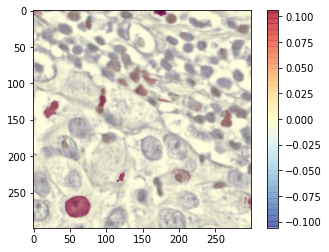

In [13]:
heatmap_immune_1 = heatmap1+heatmap2+heatmap3+heatmap4+heatmap5
heatmap_immune_1[heatmap_immune_1<0]=0
plt.imshow(image1,alpha=1)
plt.imshow(heatmap_immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_immune_1.max(), vmin=-heatmap_immune_1.max())
plt.colorbar()

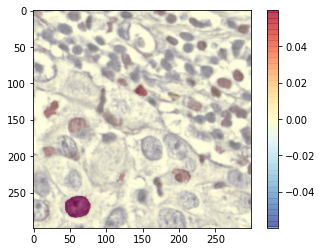

In [14]:
heatmap_cancer_1 = heatmap6+heatmap7+heatmap8+heatmap9+heatmap10
heatmap_cancer_1[heatmap_cancer_1<0]=0
plt.imshow(image1)
plt.imshow(heatmap_cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_cancer_1.max(), vmin=-heatmap_cancer_1.max())
plt.colorbar()

In [15]:
image2 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-10071-15247-299.jpeg'))
immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation_2_1 = explainer.explain_instance(image2, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_2 = explainer.explain_instance(image2, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_3 = explainer.explain_instance(image2, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_4 = explainer.explain_instance(image2, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_5 = explainer.explain_instance(image2, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

explanation_2_6 = explainer.explain_instance(image2, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_7 = explainer.explain_instance(image2, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_8 = explainer.explain_instance(image2, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_9 = explainer.explain_instance(image2, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_2_10 = explainer.explain_instance(image2, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

temp_2_1, mask_2_1 = explanation_2_1.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_2, mask_2_2 = explanation_2_2.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_3, mask_2_3 = explanation_2_3.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_4, mask_2_4 = explanation_2_4.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_5, mask_2_5 = explanation_2_5.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_6, mask_2_6 = explanation_2_6.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_7, mask_2_7 = explanation_2_7.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_8, mask_2_8 = explanation_2_8.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_9, mask_2_9 = explanation_2_9.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_2_10, mask_2_10 = explanation_2_10.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
immune_mask_2 = (mask_2_1+mask_2_2+mask_2_3+mask_2_4+mask_2_5)/5
cancer_mask_2 = (mask_2_6+mask_2_7+mask_2_8+mask_2_9+mask_2_10)/5

dict_2heatmap_2_1 = dict(explanation_2_1.local_exp[1])
heatmap_2_1 = np.vectorize(dict_2heatmap_2_1.get)(explanation_2_1.segments)

dict_2heatmap_2_2 = dict(explanation_2_2.local_exp[1])
heatmap_2_2 = np.vectorize(dict_2heatmap_2_2.get)(explanation_2_2.segments)

dict_2heatmap_2_3 = dict(explanation_2_3.local_exp[1])
heatmap_2_3 = np.vectorize(dict_2heatmap_2_3.get)(explanation_2_3.segments)

dict_2heatmap_2_4 = dict(explanation_2_4.local_exp[1])
heatmap_2_4 = np.vectorize(dict_2heatmap_2_4.get)(explanation_2_4.segments)

dict_2heatmap_2_5 = dict(explanation_2_5.local_exp[1])
heatmap_2_5 = np.vectorize(dict_2heatmap_2_5.get)(explanation_2_5.segments)



dict_2heatmap_2_6 = dict(explanation_2_6.local_exp[1])
heatmap_2_6 = np.vectorize(dict_2heatmap_2_6.get)(explanation_2_6.segments)

dict_2heatmap_2_7 = dict(explanation_2_7.local_exp[1])
heatmap_2_7 = np.vectorize(dict_2heatmap_2_7.get)(explanation_2_7.segments)

dict_2heatmap_2_8 = dict(explanation_2_8.local_exp[1])
heatmap_2_8 = np.vectorize(dict_2heatmap_2_8.get)(explanation_2_8.segments)

dict_2heatmap_2_9 = dict(explanation_2_9.local_exp[1])
heatmap_2_9 = np.vectorize(dict_2heatmap_2_9.get)(explanation_2_9.segments)

dict_2heatmap_2_10 = dict(explanation_2_10.local_exp[1])
heatmap_2_10 = np.vectorize(dict_2heatmap_2_10.get)(explanation_2_10.segments)

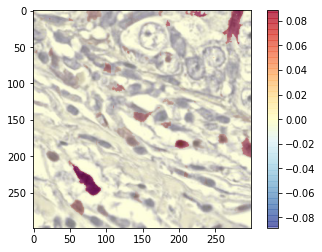

In [17]:
heatmap_2__immune_1 = heatmap_2_1+heatmap_2_2+heatmap_2_3+heatmap_2_4+heatmap_2_5
heatmap_2__immune_1[heatmap_2__immune_1<0]=0
plt.imshow(image2)
plt.imshow(heatmap_2__immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_2__immune_1.max(), vmin=-heatmap_2__immune_1.max())
plt.colorbar()

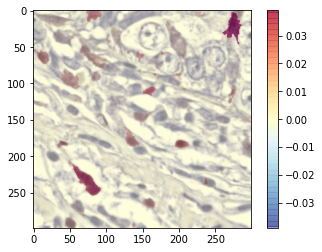

In [18]:
heatmap_2__cancer_1 = heatmap_2_6+heatmap_2_7+heatmap_2_8+heatmap_2_9+heatmap_2_10
heatmap_2__cancer_1[heatmap_2__cancer_1<0]=0
plt.imshow(image2)
plt.imshow(heatmap_2__cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_2__cancer_1.max(), vmin=-heatmap_2__cancer_1.max())
plt.colorbar()

In [19]:
image3 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-7608-12973-299.jpeg'))

immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation_3_1 = explainer.explain_instance(image3, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_2 = explainer.explain_instance(image3, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_3 = explainer.explain_instance(image3, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_4 = explainer.explain_instance(image3, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_5 = explainer.explain_instance(image3, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

explanation_3_6 = explainer.explain_instance(image3, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_7 = explainer.explain_instance(image3, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_8 = explainer.explain_instance(image3, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_9 = explainer.explain_instance(image3, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_3_10 = explainer.explain_instance(image3, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

temp_3_1, mask_3_1 = explanation_3_1.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_2, mask_3_2 = explanation_3_2.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_3, mask_3_3 = explanation_3_3.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_4, mask_3_4 = explanation_3_4.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_5, mask_3_5 = explanation_3_5.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_6, mask_3_6 = explanation_3_6.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_7, mask_3_7 = explanation_3_7.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_8, mask_3_8 = explanation_3_8.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_9, mask_3_9 = explanation_3_9.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_3_10, mask_3_10 = explanation_3_10.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
immune_mask_3 = (mask_3_1+mask_3_2+mask_3_3+mask_3_4+mask_3_5)/5
cancer_mask_3 = (mask_3_6+mask_3_7+mask_3_8+mask_3_9+mask_3_10)/5

dict_3_heatmap_3_1 = dict(explanation_3_1.local_exp[1])
heatmap_3_1 = np.vectorize(dict_3_heatmap_3_1.get)(explanation_3_1.segments)

dict_3_heatmap_3_2 = dict(explanation_3_2.local_exp[1])
heatmap_3_2 = np.vectorize(dict_3_heatmap_3_2.get)(explanation_3_2.segments)

dict_3_heatmap_3_3 = dict(explanation_3_3.local_exp[1])
heatmap_3_3 = np.vectorize(dict_3_heatmap_3_3.get)(explanation_3_3.segments)

dict_3_heatmap_3_4 = dict(explanation_3_4.local_exp[1])
heatmap_3_4 = np.vectorize(dict_3_heatmap_3_4.get)(explanation_3_4.segments)

dict_3_heatmap_3_5 = dict(explanation_3_5.local_exp[1])
heatmap_3_5 = np.vectorize(dict_3_heatmap_3_5.get)(explanation_3_5.segments)



dict_3_heatmap_3_6 = dict(explanation_3_6.local_exp[1])
heatmap_3_6 = np.vectorize(dict_3_heatmap_3_6.get)(explanation_3_6.segments)

dict_3_heatmap_3_7 = dict(explanation_3_7.local_exp[1])
heatmap_3_7 = np.vectorize(dict_3_heatmap_3_7.get)(explanation_3_7.segments)

dict_3_heatmap_3_8 = dict(explanation_3_8.local_exp[1])
heatmap_3_8 = np.vectorize(dict_3_heatmap_3_8.get)(explanation_3_8.segments)

dict_3_heatmap_3_9 = dict(explanation_3_9.local_exp[1])
heatmap_3_9 = np.vectorize(dict_3_heatmap_3_9.get)(explanation_3_9.segments)

dict_3_heatmap_3_10 = dict(explanation_3_10.local_exp[1])
heatmap_3_10 = np.vectorize(dict_3_heatmap_3_10.get)(explanation_3_10.segments)

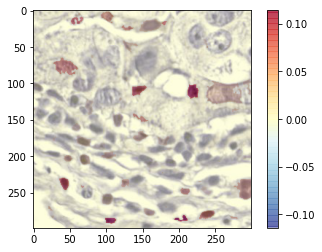

In [21]:
heatmap_3__immune_1 = heatmap_3_1+heatmap_3_2+heatmap_3_3+heatmap_3_4+heatmap_3_5
heatmap_3__immune_1[heatmap_3__immune_1<0]=0
plt.imshow(image3)
plt.imshow(heatmap_3__immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_3__immune_1.max(), vmin=-heatmap_3__immune_1.max())
plt.colorbar()

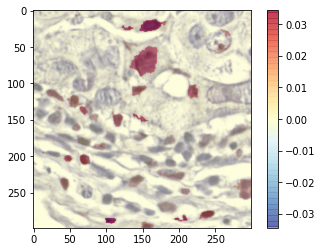

In [22]:
heatmap_3__cancer_1 = heatmap_3_6+heatmap_3_7+heatmap_3_8+heatmap_3_9+heatmap_3_10
heatmap_3__cancer_1[heatmap_3__cancer_1<0]=0
plt.imshow(image3)
plt.imshow(heatmap_3__cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_3__cancer_1.max(), vmin=-heatmap_3__cancer_1.max())
plt.colorbar()

In [23]:
image4 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-7174-11711-299.jpeg'))

immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation_4_1 = explainer.explain_instance(image4, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_2 = explainer.explain_instance(image4, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_3 = explainer.explain_instance(image4, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_4 = explainer.explain_instance(image4, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_5 = explainer.explain_instance(image4, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

explanation_4_6 = explainer.explain_instance(image4, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_7 = explainer.explain_instance(image4, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_8 = explainer.explain_instance(image4, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_9 = explainer.explain_instance(image4, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_4_10 = explainer.explain_instance(image4, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

temp_4_1, mask_4_1 = explanation_4_1.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_2, mask_4_2 = explanation_4_2.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_3, mask_4_3 = explanation_4_3.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_4, mask_4_4 = explanation_4_4.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_5, mask_4_5 = explanation_4_5.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_6, mask_4_6 = explanation_4_6.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_7, mask_4_7 = explanation_4_7.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_8, mask_4_8 = explanation_4_8.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_9, mask_4_9 = explanation_4_9.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_4_10, mask_4_10 = explanation_4_10.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
immune_mask_4 = (mask_4_1+mask_4_2+mask_4_3+mask_4_4+mask_4_5)/5
cancer_mask_4 = (mask_4_6+mask_4_7+mask_4_8+mask_4_9+mask_4_10)/5

dict_4_heatmap_4_1 = dict(explanation_4_1.local_exp[1])
heatmap_4_1 = np.vectorize(dict_4_heatmap_4_1.get)(explanation_4_1.segments)

dict_4_heatmap_4_2 = dict(explanation_4_2.local_exp[1])
heatmap_4_2 = np.vectorize(dict_4_heatmap_4_2.get)(explanation_4_2.segments)

dict_4_heatmap_4_3 = dict(explanation_4_3.local_exp[1])
heatmap_4_3 = np.vectorize(dict_4_heatmap_4_3.get)(explanation_4_3.segments)

dict_4_heatmap_4_4 = dict(explanation_4_4.local_exp[1])
heatmap_4_4 = np.vectorize(dict_4_heatmap_4_4.get)(explanation_4_4.segments)

dict_4_heatmap_4_5 = dict(explanation_4_5.local_exp[1])
heatmap_4_5 = np.vectorize(dict_4_heatmap_4_5.get)(explanation_4_5.segments)


dict_4_heatmap_4_6 = dict(explanation_4_6.local_exp[1])
heatmap_4_6 = np.vectorize(dict_4_heatmap_4_6.get)(explanation_4_6.segments)

dict_4_heatmap_4_7 = dict(explanation_4_7.local_exp[1])
heatmap_4_7 = np.vectorize(dict_4_heatmap_4_7.get)(explanation_4_7.segments)

dict_4_heatmap_4_8 = dict(explanation_4_8.local_exp[1])
heatmap_4_8 = np.vectorize(dict_4_heatmap_4_8.get)(explanation_4_8.segments)

dict_4_heatmap_4_9 = dict(explanation_4_9.local_exp[1])
heatmap_4_9 = np.vectorize(dict_4_heatmap_4_9.get)(explanation_4_9.segments)

dict_4_heatmap_4_10 = dict(explanation_4_10.local_exp[1])
heatmap_4_10 = np.vectorize(dict_4_heatmap_4_10.get)(explanation_4_10.segments)

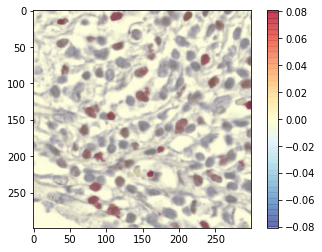

In [25]:
heatmap_4__immune_1 = heatmap_4_1+heatmap_4_2+heatmap_4_3+heatmap_4_4+heatmap_4_5
heatmap_4__immune_1[heatmap_4__immune_1<0]=0
plt.imshow(image4)
plt.imshow(heatmap_4__immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_4__immune_1.max(), vmin=-heatmap_4__immune_1.max())
plt.colorbar()


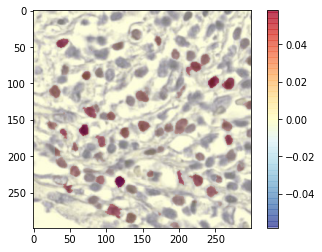

In [26]:
heatmap_4__cancer_1 = heatmap_4_6+heatmap_4_7+heatmap_4_8+heatmap_4_9+heatmap_4_10
heatmap_4__cancer_1[heatmap_4__cancer_1<0]=0
plt.imshow(image4)
plt.imshow(heatmap_4__cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_4__cancer_1.max(), vmin=-heatmap_4__cancer_1.max())
plt.colorbar()

In [27]:
image5 = np.asarray(image_fun.load_img(Path+'LIME/FFPE-8190-10955-299.jpeg'))

immune_genes = ['CD74','CD24','CD63','CD81','CD151']
cancer_genes = ['COX6C','TP53','PABPC1','GNAS','B2M']

explanation_5_1 = explainer.explain_instance(image5, model_predict_gene(immune_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_2 = explainer.explain_instance(image5, model_predict_gene(immune_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_3 = explainer.explain_instance(image5, model_predict_gene(immune_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_4 = explainer.explain_instance(image5, model_predict_gene(immune_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_5 = explainer.explain_instance(image5, model_predict_gene(immune_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

explanation_5_6 = explainer.explain_instance(image5, model_predict_gene(cancer_genes[0]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_7 = explainer.explain_instance(image5, model_predict_gene(cancer_genes[1]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_8 = explainer.explain_instance(image5, model_predict_gene(cancer_genes[2]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_9 = explainer.explain_instance(image5, model_predict_gene(cancer_genes[3]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)
explanation_5_10 = explainer.explain_instance(image5, model_predict_gene(cancer_genes[4]), top_labels=2, hide_color=0, num_samples=1000, segmentation_fn=watershed_segment)

temp_5_1, mask_5_1 = explanation_5_1.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_2, mask_5_2 = explanation_5_2.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_3, mask_5_3 = explanation_5_3.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_4, mask_5_4 = explanation_5_4.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_5, mask_5_5 = explanation_5_5.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_6, mask_5_6 = explanation_5_6.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_7, mask_5_7 = explanation_5_7.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_8, mask_5_8 = explanation_5_8.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_9, mask_5_9 = explanation_5_9.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)
temp_5_10, mask_5_10 = explanation_5_10.get_image_and_mask(1, positive_only=False, num_features=1000, hide_rest=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
immune_mask_5 = (mask_5_1+mask_5_2+mask_5_3+mask_5_4+mask_5_5)/5
cancer_mask_5 = (mask_5_6+mask_5_7+mask_5_8+mask_5_9+mask_5_10)/5

dict_5_heatmap_5_1 = dict(explanation_5_1.local_exp[1])
heatmap_5_1 = np.vectorize(dict_5_heatmap_5_1.get)(explanation_5_1.segments)

dict_5_heatmap_5_2 = dict(explanation_5_2.local_exp[1])
heatmap_5_2 = np.vectorize(dict_5_heatmap_5_2.get)(explanation_5_2.segments)

dict_5_heatmap_5_3 = dict(explanation_5_3.local_exp[1])
heatmap_5_3 = np.vectorize(dict_5_heatmap_5_3.get)(explanation_5_3.segments)

dict_5_heatmap_5_4 = dict(explanation_5_4.local_exp[1])
heatmap_5_4 = np.vectorize(dict_5_heatmap_5_4.get)(explanation_5_4.segments)

dict_5_heatmap_5_5 = dict(explanation_5_5.local_exp[1])
heatmap_5_5 = np.vectorize(dict_5_heatmap_5_5.get)(explanation_5_5.segments)



dict_5_heatmap_5_6 = dict(explanation_5_6.local_exp[1])
heatmap_5_6 = np.vectorize(dict_5_heatmap_5_6.get)(explanation_5_6.segments)

dict_5_heatmap_5_7 = dict(explanation_5_7.local_exp[1])
heatmap_5_7 = np.vectorize(dict_5_heatmap_5_7.get)(explanation_5_7.segments)

dict_5_heatmap_5_8 = dict(explanation_5_8.local_exp[1])
heatmap_5_8 = np.vectorize(dict_5_heatmap_5_8.get)(explanation_5_8.segments)

dict_5_heatmap_5_9 = dict(explanation_5_9.local_exp[1])
heatmap_5_9 = np.vectorize(dict_5_heatmap_5_9.get)(explanation_5_9.segments)

dict_5_heatmap_5_10 = dict(explanation_5_10.local_exp[1])
heatmap_5_10 = np.vectorize(dict_5_heatmap_5_10.get)(explanation_5_10.segments)

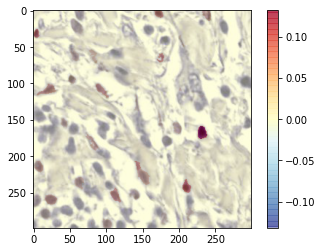

In [29]:
heatmap_5__immune_1 = heatmap_5_1+heatmap_5_2+heatmap_5_3+heatmap_5_4+heatmap_5_5
heatmap_5__immune_1[heatmap_5__immune_1<0]=0
plt.imshow(image5)
plt.imshow(heatmap_5__immune_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_5__immune_1.max(), vmin=-heatmap_5__immune_1.max())
plt.colorbar()

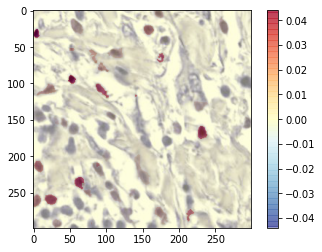

In [30]:
heatmap_5__cancer_1 = heatmap_5_6+heatmap_5_7+heatmap_5_8+heatmap_5_9+heatmap_5_10
heatmap_5__cancer_1[heatmap_5__cancer_1<0]=0
plt.imshow(image5)
plt.imshow(heatmap_5__cancer_1, alpha=0.5, cmap = 'RdYlBu_r', vmax=heatmap_5__cancer_1.max(), vmin=-heatmap_5__cancer_1.max())
plt.colorbar()

## Computing Nuclei Score with Reference as MaskRCNN Web-App

In [31]:
cell_summary_FFPE_7318_11963_299_lymphocyte_stroma = pd.concat([cell_summary(Path+'LIME/cell_summary_FFPE-7318-11963-299.csv',"Stroma"),cell_summary(Path+'LIME/cell_summary_FFPE-7318-11963-299.csv',"Lymphocyte")]).reset_index()
cell_summary_FFPE_7318_11963_299_Tumor = cell_summary(Path+'LIME/cell_summary_FFPE-7318-11963-299.csv',"Tumor").reset_index()

cell_summary_FFPE_10071_15247_299_lymphocyte_stroma = pd.concat([cell_summary(Path+'LIME/cell_summary_FFPE-10071-15247-299.csv',"Stroma"),cell_summary(Path+'LIME/cell_summary_FFPE-10071-15247-299.csv',"Lymphocyte")]).reset_index()
cell_summary_FFPE_10071_15247_299_Tumor = cell_summary(Path+'LIME/cell_summary_FFPE-10071-15247-299.csv',"Tumor").reset_index()

cell_summary_FFPE_7608_12973_299_lymphocyte_stroma = pd.concat([cell_summary(Path+'LIME/cell_summary_FFPE-7608-12973-299.csv',"Stroma"),cell_summary(Path+'LIME/cell_summary_FFPE-7608-12973-299.csv',"Lymphocyte")]).reset_index()
cell_summary_FFPE_7608_12973_299_Tumor = cell_summary(Path+'LIME/cell_summary_FFPE-7608-12973-299.csv',"Tumor").reset_index()

cell_summary_FFPE_7174_11711_299_lymphocyte_stroma = pd.concat([cell_summary(Path+'LIME/cell_summary_FFPE-7174-11711-299.csv',"Stroma"),cell_summary(Path+'LIME/cell_summary_FFPE-7174-11711-299.csv',"Lymphocyte")]).reset_index()
cell_summary_FFPE_7174_11711_299_Tumor = cell_summary(Path+'LIME/cell_summary_FFPE-7174-11711-299.csv',"Tumor").reset_index()

cell_summary_FFPE_8190_10955_299_lymphocyte_stroma = pd.concat([cell_summary(Path+'LIME/cell_summary_FFPE-8190-10955-299.csv',"Stroma"),cell_summary(Path+'LIME/cell_summary_FFPE-8190-10955-299.csv',"Lymphocyte")]).reset_index()
cell_summary_FFPE_8190_10955_299_Tumor = cell_summary(Path+'LIME/cell_summary_FFPE-8190-10955-299.csv',"Tumor").reset_index()


masks = [mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8, mask9, mask10]
masks_2 = [mask_2_1, mask_2_2, mask_2_3, mask_2_4, mask_2_5, mask_2_6, mask_2_7, mask_2_8, mask_2_9, mask_2_10]
masks_3 = [mask_3_1, mask_3_2, mask_3_3, mask_3_4, mask_3_5, mask_3_6, mask_3_7, mask_3_8, mask_3_9, mask_3_10]
masks_4 = [mask_4_1, mask_4_2, mask_4_3, mask_4_4, mask_4_5, mask_4_6, mask_4_7, mask_4_8, mask_4_9, mask_4_10]
masks_5 = [mask_5_1, mask_5_2, mask_5_3, mask_5_4, mask_5_5, mask_5_6, mask_5_7, mask_5_8, mask_5_9, mask_5_10]


lymphocytes_score = []; tumor_score = []

for i in range(0,len(masks)):
    lymphocytes_score.append(IOU(cell_summary_FFPE_7318_11963_299_lymphocyte_stroma,masks[i]))
    
for i in range(0,len(masks_2)):
    lymphocytes_score.append(IOU(cell_summary_FFPE_10071_15247_299_lymphocyte_stroma,masks_2[i]))

for i in range(0,len(masks_3)):
    lymphocytes_score.append(IOU(cell_summary_FFPE_7608_12973_299_lymphocyte_stroma,masks_3[i]))

for i in range(0,len(masks_4)):
    lymphocytes_score.append(IOU(cell_summary_FFPE_7174_11711_299_lymphocyte_stroma,masks_4[i]))

for i in range(0,len(masks_5)):
    lymphocytes_score.append(IOU(cell_summary_FFPE_8190_10955_299_lymphocyte_stroma,masks_5[i]))

for i in range(0,len(masks)):
    tumor_score.append(IOU(cell_summary_FFPE_7318_11963_299_lymphocyte_stroma,masks[i]))

for i in range(0,len(masks_2)):
    tumor_score.append(IOU(cell_summary_FFPE_10071_15247_299_Tumor,masks_2[i]))

for i in range(0,len(masks_3)):
    tumor_score.append(IOU(cell_summary_FFPE_7608_12973_299_Tumor,masks_3[i]))

for i in range(0,len(masks_4)):
    tumor_score.append(IOU(cell_summary_FFPE_7174_11711_299_Tumor,masks_4[i]))

for i in range(0,len(masks_5)):
    tumor_score.append(IOU(cell_summary_FFPE_8190_10955_299_Tumor,masks_5[i]))


## Computing p-value

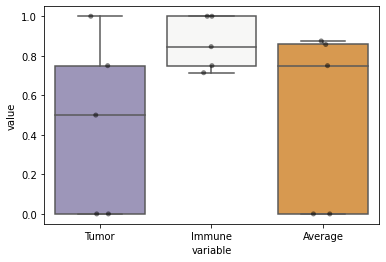

In [32]:
accuracy_1 = LIME_p_value(heatmap_cancer_1, heatmap_immune_1, cell_summary_FFPE_7318_11963_299_Tumor, cell_summary_FFPE_7318_11963_299_lymphocyte_stroma, cancer_mask_1, immune_mask_1)
accuracy_2 = LIME_p_value(heatmap_2__cancer_1, heatmap_2__immune_1, cell_summary_FFPE_10071_15247_299_Tumor, cell_summary_FFPE_10071_15247_299_lymphocyte_stroma, cancer_mask_2, immune_mask_2)
accuracy_3 = LIME_p_value(heatmap_3__cancer_1, heatmap_3__immune_1, cell_summary_FFPE_7608_12973_299_Tumor, cell_summary_FFPE_7608_12973_299_lymphocyte_stroma, cancer_mask_3, immune_mask_3)
accuracy_4 = LIME_p_value(heatmap_4__cancer_1, heatmap_4__immune_1, cell_summary_FFPE_7174_11711_299_Tumor, cell_summary_FFPE_7174_11711_299_lymphocyte_stroma, cancer_mask_4, immune_mask_4)
accuracy_5 = LIME_p_value(heatmap_5__cancer_1, heatmap_5__immune_1, cell_summary_FFPE_8190_10955_299_Tumor, cell_summary_FFPE_8190_10955_299_lymphocyte_stroma, cancer_mask_5, immune_mask_5)


accuracy_tumor = [accuracy_1[1],accuracy_2[1],accuracy_3[1],accuracy_4[1],accuracy_5[1]]
accuracy_immune = [accuracy_1[3],accuracy_2[3],accuracy_3[3],accuracy_4[3],accuracy_5[3]]
accuracy_average = [accuracy_1[5],accuracy_2[5],accuracy_3[5],accuracy_4[5],accuracy_5[5]]


data = [accuracy_tumor,accuracy_immune,accuracy_average]
LIME_accuracy_df = pd.DataFrame(data, index = ['Tumor', 'Immune', 'Average']).T
LIME_accuracy_df = pd.melt(LIME_accuracy_df)
LIME_accuracy_df.fillna(0,inplace=True)

sns.boxplot(x="variable",y='value',data=LIME_accuracy_df, palette="PuOr_r")
sns.stripplot(x="variable",y='value',data=LIME_accuracy_df, color = 'black',alpha = 0.5)

### Extra

In [33]:
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
lymp_df = pd.DataFrame(lymphocytes_score)
lymp_df['Immune_nuclei_category'] = (["immune"]*5+["cancer"]*5)*5
sns.boxplot(x="Immune_nuclei_category",y=0,data=lymp_df, palette="PuOr_r")
sns.stripplot(x="Immune_nuclei_category",y=0,data=lymp_df, color = 'black',alpha = 0.5)

plt.subplot(1,2,2)
tumor_df = pd.DataFrame(tumor_score)
tumor_df['Tumor_nuclei_category'] = (["immune"]*5+["cancer"]*5)*5
sns.boxplot(x="Tumor_nuclei_category",y=0,data=tumor_df, palette="PuOr_r")
sns.stripplot(x="Tumor_nuclei_category",y=0,data=tumor_df, color = 'black',alpha = 0.5)